I tried a custom CNN model and other pretrained models (Xception,ResNet50, MobileNet, EfficientNetB0, ResNet101). However, I haven't obtained sufficient results in respect of accuracy and F1 score. This dataset is unbalanced. For example, the Cavity class has only 22 samples in the test set. I tried the 'class weights' method, but there was no improvement. I used a basic data augmentation method.


I have used the following methods.

* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,
* I used several image processing methods for images <b>(Contrast Limited AHE (CLAHE)</b>[1])
* I used a pretrained <b>DenseNet201</b> architecture for the feature extraction stage,
* <b>elu</b> activation function during the classification stage,


## Image Processing Operation
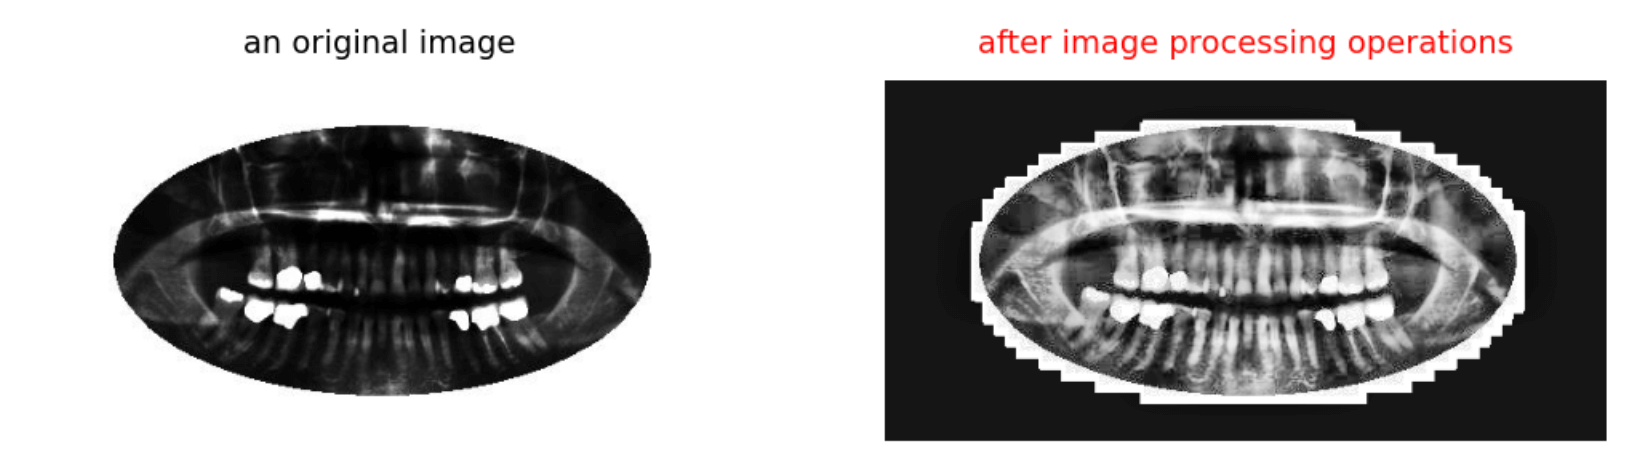

## Test Set Predictions
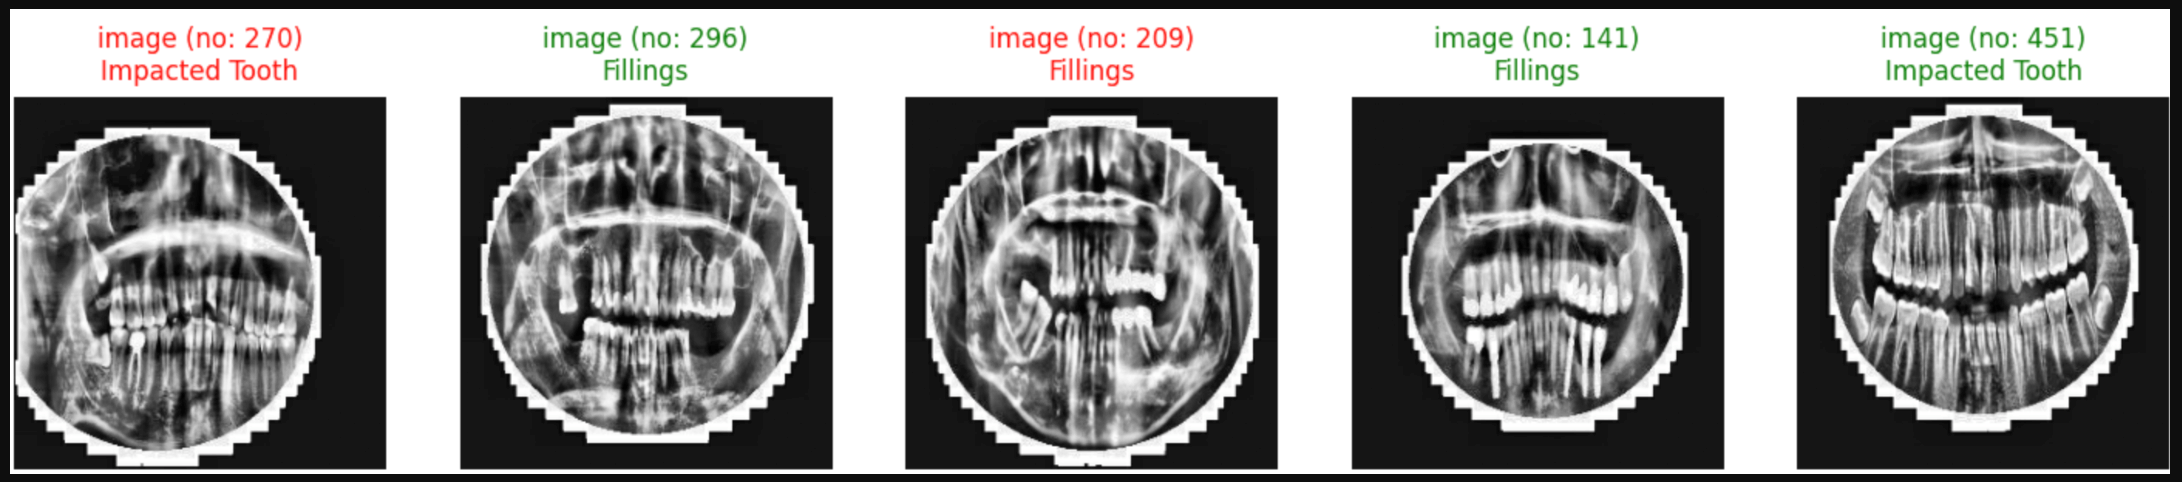
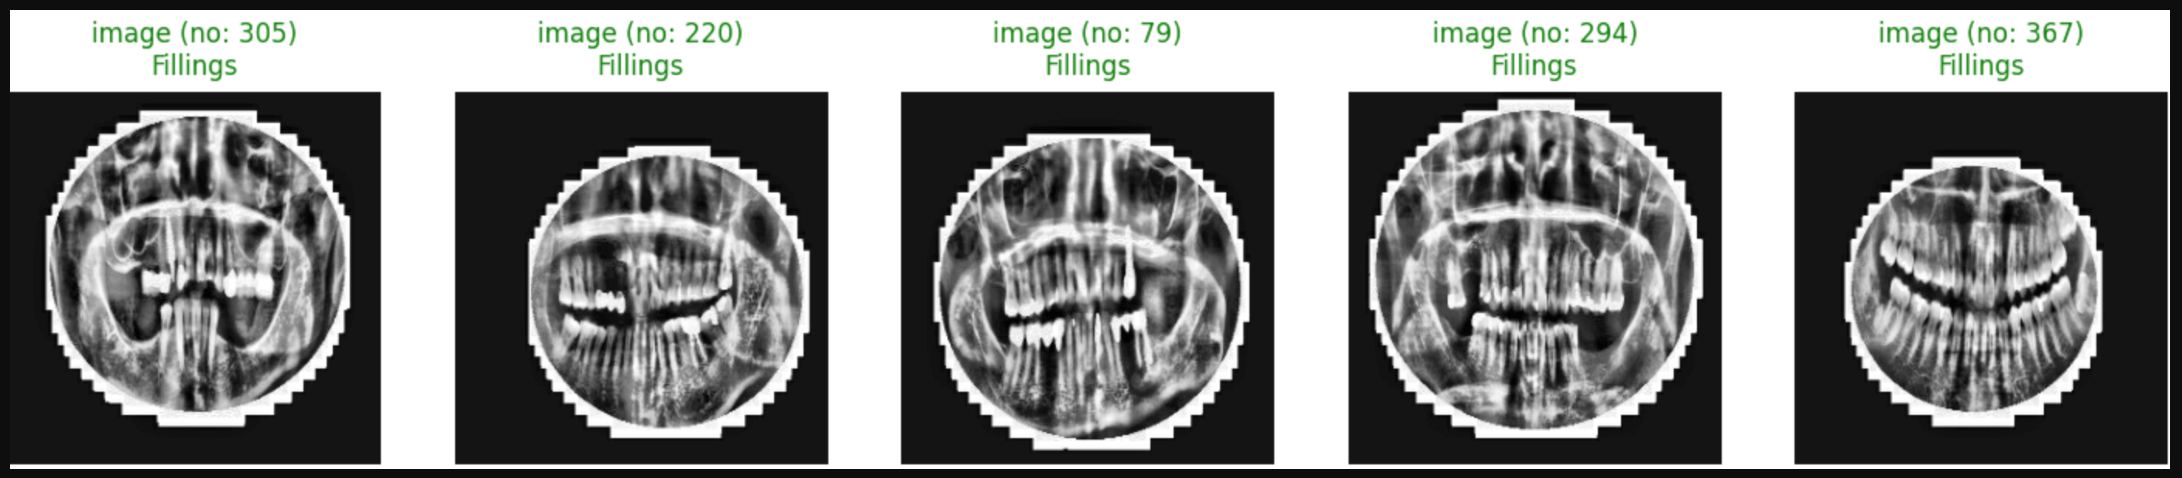

## My Another Projects
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

In [ ]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.applications import Xception,ResNet50, DenseNet201,MobileNet, EfficientNetB0, ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, MaxPooling2D, Add, AveragePooling2D, Flatten,Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.layers import Layer,Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


SEED = 10
IMG_SIZE = 256, 256
BATCH_SIZE = 64

In [ ]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

# <span style="color:#e74c3c;"> Preprocessing </span>


In [ ]:
# chosing a random image from the train dataset
original_train_images =  sorted(os.listdir('/kaggle/input/dental-radiography/train'))
org_img_path =  np.random.permutation(original_train_images)[0]
img = cv2.imread(os.path.join('/kaggle/input/dental-radiography/train',org_img_path))[:,::,1]


# A basic segmentation of the image from the background
# In this stage I wanted to reduce the white pixel number 
img2 = img - 255
kernel = np.ones((2,2))
kernel2 = np.ones((3,3))
dilated_mask = cv2.dilate(img2, kernel, iterations = 3)
ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY) 
dilated_mask2 = cv2.dilate(thresh, kernel2, iterations = 3)
img = img / 255.0
res_img = dilated_mask2*img
res_img = np.uint8(res_img)

# CLAHE operation
clahe_op = cv2.createCLAHE(clipLimit= 20)
final_img = clahe_op.apply(res_img)
    
fig, axs = plt.subplots(1,2, dpi = 200)

axs[0].imshow(img,  cmap = 'gray')
axs[0].axis('off')
axs[0].set_title('an original image', fontsize = 7)

axs[1].imshow(final_img,  cmap = 'gray')
axs[1].axis('off')
axs[1].set_title('after image processing operations', fontsize = 7, color = 'red')

In [ ]:
# Creating new directories
os.mkdir(os.path.join('/kaggle/working/', 'train'))
os.mkdir(os.path.join('/kaggle/working/', 'valid'))
os.mkdir(os.path.join('/kaggle/working/', 'test'))

In [ ]:
# Image processing function
# reading -> background segmentation -> adaptive histogram equalization (CLAHE)

def new_img(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :
        try:
            img = cv2.imread(os.path.join(main_path, i))[:,::,1]
            img2 = img - 255
            kernel = np.ones((2,2))
            kernel2 = np.ones((3,3))
            
            dilated_mask = cv2.dilate(img2, kernel, iterations = 3)
            ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY) 
            dilated_mask2 = cv2.dilate(thresh, kernel2, iterations = 3)
            img = img / 255.0
            res_img = dilated_mask2*img
            
            res_img = np.uint8(res_img)

            clahe_op = cv2.createCLAHE(clipLimit= 20) # CLAHE function
            final_img = clahe_op.apply(res_img)
            
            
            cv2.imwrite(os.path.join(target_path, i), final_img)
        except TypeError:
            pass

In [ ]:
# Applying the image processing function to all images
new_img('/kaggle/input/dental-radiography/train', '/kaggle/working/train')
new_img('/kaggle/input/dental-radiography/valid', '/kaggle/working/valid')
new_img('/kaggle/input/dental-radiography/test', '/kaggle/working/test')

In [ ]:
train_data = pd.read_csv('/kaggle/input/dental-radiography/train/_annotations.csv')
validation_data = pd.read_csv('/kaggle/input/dental-radiography/valid/_annotations.csv')
test_data = pd.read_csv('/kaggle/input/dental-radiography/test/_annotations.csv')

# look-up table
classes = {0: 'Fillings', 1: 'Implant', 2: 'Impacted Tooth', 3: 'Cavity'}

def create_classes(X):
    if X == 'Fillings':
        return 0
    elif X == 'Implant':
        return 1
    elif X == 'Impacted Tooth':
        return 2
    elif X == 'Cavity':
        return 3
    else:
        print('MISSING')
    
    
train_data['encoded_class'] = train_data['class'].apply(create_classes)
validation_data['encoded_class'] = validation_data['class'].apply(create_classes)
test_data['encoded_class'] = test_data['class'].apply(create_classes)


train_data['full_path'] = '/kaggle/working/train/' + train_data['filename']
validation_data['full_path'] = '/kaggle/working/valid/' + validation_data['filename']
test_data['full_path'] = '/kaggle/working/test/' + test_data['filename']


print("train images: ", train_data.shape[0])
print("validation images: ", validation_data.shape[0])
print("test images: ", test_data.shape[0])

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [ ]:
# Reading and resizing images
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size =  (IMG_SIZE) )
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Basic data augmentation - randomly flips left or right
def img_augmentation(image, label):

    radn_num = np.random.randint(0, 100)
    if radn_num % 2 == 0:
        img = tf.image.random_flip_left_right(image)
        return img, label
    else:
        return image, label

In [ ]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_path'], train_data['encoded_class'] ))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
                 .map(img_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(train_data.shape[0])
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))


valid_loader = tf.data.Dataset.from_tensor_slices((validation_data['full_path'], validation_data['encoded_class'] ))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_path'], test_data['encoded_class'] ))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

# <span style="color:#e74c3c;"> DenseNet201 </span> Model


In [ ]:
with strategy.scope():
    pretrained_model = DenseNet201(weights='imagenet',include_top=False ,input_shape=[*IMG_SIZE, 3])
    pretrained_model.trainable = True

    inp = Input(shape = (*IMG_SIZE, 3))
    densenet = pretrained_model(inp)
    
    X = GlobalAveragePooling2D()(densenet)
    X = Dense(256, activation = 'elu')(X)
    X = Dropout(0.3)(X)
    
    X = Dense(128, activation = 'elu')(X)
    X = Dropout(0.2)(X)
    
    X = Dense(32, activation = 'elu')(X)
    
    out = Dense(4, activation = 'softmax')(X)
    
    model = Model(inputs = inp, outputs = out)
    
    my_callbacks = [EarlyStopping(min_delta = 0.0001, monitor = 'loss', patience = 40 ),
                   ReduceLROnPlateau( monitor="val_loss", factor=0.1, patience=15)]

    
model.compile(optimizer  = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# <span style="color:#e74c3c;"> Training</span> 

In [ ]:
hist = model.fit(train_dataset, epochs = 100,validation_data = valid_dataset, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training</span> Results

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'validation loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['accuracy'])
axs[1].plot(hist.history['val_accuracy'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize = 10)

# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [ ]:
with strategy.scope():
    test_eval = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))

In [ ]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.argmax(pred, axis = 1)

# <span style="color:#e74c3c;"> Classification </span> Report

In [ ]:
clf = classification_report(test_data['encoded_class'], pred, target_names = list(classes.values()))
print(clf)

# <span style="color:#e74c3c;"> Confusion </span> Matrix

In [ ]:
cm = confusion_matrix(test_data['encoded_class'], pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(6,6))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [ ]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img , cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img , cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

In [ ]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()